# environment

In [1]:
import os, yaml, re
import json
import base64
import zlib
import math

import warnings
from numba import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning) 

from pathlib import Path
import numpy as np
import scipy as sc
import pandas as pd

import loompy as lp
import scanpy as sc

import matplotlib.pyplot as plt

from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from adjustText import adjust_text

from matplotlib import rcParams
from matplotlib.pyplot import rc_context
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import networkx as nx

In [3]:
def count_unique_index(df, by):                                                                                                                                                 
    return df.groupby(by).size().reset_index().rename(columns={0:'count'})

In [4]:
def top_columns_for_each_row(df, n=10):
    top_columns_list = []
    for index, row in df.iterrows():
        top_columns = row.nlargest(n).index.tolist()
        top_columns_list.append(top_columns)
    top_columns_df = pd.DataFrame(top_columns_list, columns=[f'Top_{i+1}' for i in range(n)])
    return top_columns_df

In [5]:
def find_keys_for_value_in_nested_dict(nested_dict, target_value):
    keys = []
    for key, value in nested_dict.items():
        if target_value in value:
            keys.append(key)
    return keys

In [6]:
anndata = "/nfs/team205/ac65/vasculature/after_annotation/annotated_objects/vas_object_for_scenic.h5ad"

annotation_col = "ann_vas_scenic"

In [7]:
ad = sc.read_h5ad(anndata)

# RSS

In [8]:
lf = lp.connect('/lustre/scratch126/cellgen/team205/jp30/vasculature/vasculature_24Jul24/outputs/results/AUCell/vasculature_24Jul24_all_lineage_splitcomb_comb2/vasculature_24Jul24_all_lineage_splitcomb_comb2_pyscenic_output.loom', mode='r', validate=False)

In [9]:
# scenic output
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [10]:
# create a dictionary of regulons
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

/tmp/ipykernel_999205/3801288988.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():


In [11]:
lf.close()

### create anndata with regulon scores

scores in `auc_mtx`

In [12]:
ad_scenic = sc.AnnData(auc_mtx)

In [13]:
ad_scenic = ad_scenic[ad_scenic.obs_names.isin(ad.obs_names)]

add cell annotation

In [14]:
ad_scenic.obs_names_make_unique()

In [15]:
ad.obs_names_make_unique()

In [16]:
ad_scenic.obs = ad_scenic.obs.merge(ad.obs, how='left', left_index=True, right_index=True)

add original umap (based on GEX)

In [17]:
ad_scenic.obsm["X_umap_genes"] = ad[ad_scenic.obs_names].obsm["X_umap"]

In [18]:
ad_scenic.obs[annotation_col] = ad_scenic.obs[annotation_col].astype(str).astype('category')

In [19]:
ad_scenic

AnnData object with n_obs × n_vars = 7587 × 728
    obs: 'orig.ident', 'Sample', 'Winkler_annotation_ec', 'Winkler_annotation_mural', 'Winkler_annotation_mural_fine', 'donor', 'kit', 'study', 'organ_uni', 'Winkler_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Winkler_broad_annotation', 'id', 'organ', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'cell_ontology_class', 'free_annotation', 'compartment', 'age2', 'barcode', 'concat_sample_no', 'Population ', 'hospital_id', 'Organ', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'doublet_pval'

original umap

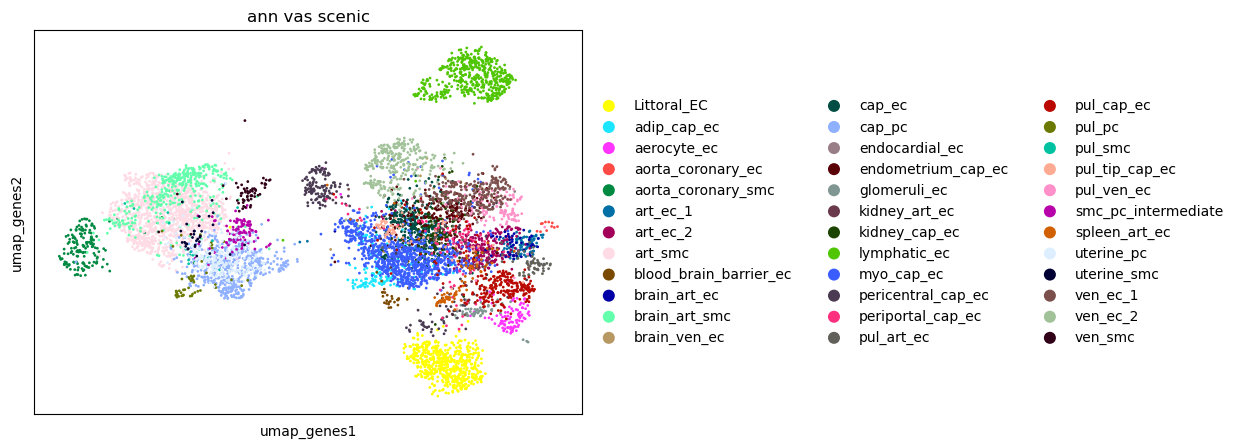

In [20]:
sc.pl.scatter(ad_scenic, color = annotation_col, basis = "umap_genes")

### plot UMAP

create embedding for cells based on regulon scores

In [21]:
sc.pp.highly_variable_genes(ad_scenic)

In [22]:
sc.pp.scale(ad_scenic)

In [23]:
sc.tl.pca(ad_scenic)

In [24]:
sc.pp.neighbors(ad_scenic)

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
sc.tl.paga(ad_scenic, groups=annotation_col)

In [26]:
ad_scenic.obs[annotation_col].value_counts()

art_smc                   1154
myo_cap_ec                 907
Littoral_EC                554
lymphatic_ec               492
cap_pc                     468
cap_ec                     374
brain_art_smc              366
ven_ec_2                   289
pul_cap_ec                 265
ven_ec_1                   264
art_ec_2                   243
uterine_pc                 215
pericentral_cap_ec         206
adip_cap_ec                205
endometrium_cap_ec         201
aorta_coronary_smc         162
pul_ven_ec                 125
kidney_cap_ec              118
smc_pc_intermediate        103
art_ec_1                   102
aerocyte_ec                101
periportal_cap_ec           83
spleen_art_ec               82
pul_tip_cap_ec              66
pul_art_ec                  66
glomeruli_ec                63
ven_smc                     59
pul_pc                      50
brain_art_ec                48
blood_brain_barrier_ec      44
uterine_smc                 32
kidney_art_ec               21
pul_smc 

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


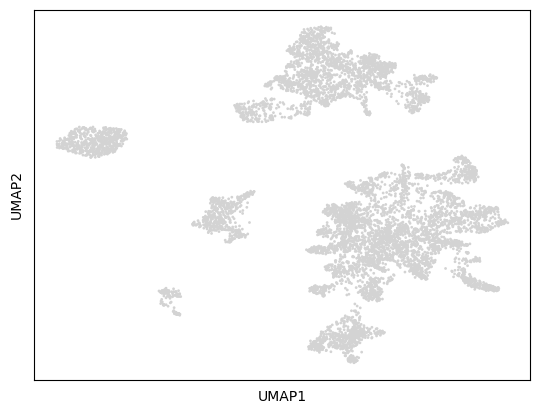

In [27]:
sc.tl.umap(ad_scenic)
sc.pl.umap(ad_scenic)

In [28]:
ad_scenic

AnnData object with n_obs × n_vars = 7587 × 728
    obs: 'orig.ident', 'Sample', 'Winkler_annotation_ec', 'Winkler_annotation_mural', 'Winkler_annotation_mural_fine', 'donor', 'kit', 'study', 'organ_uni', 'Winkler_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Winkler_broad_annotation', 'id', 'organ', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'cell_ontology_class', 'free_annotation', 'compartment', 'age2', 'barcode', 'concat_sample_no', 'Population ', 'hospital_id', 'Organ', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'doublet_pval'

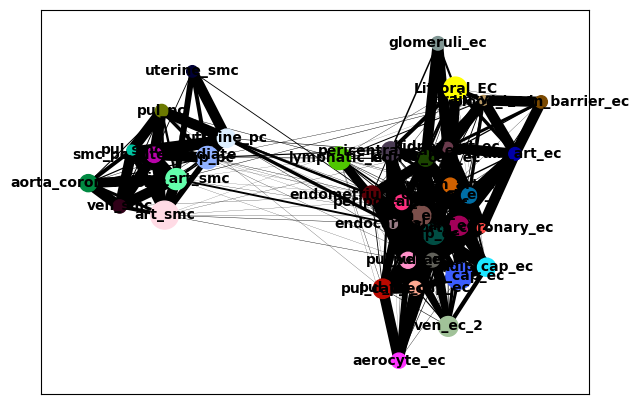

In [29]:
sc.pl.paga(ad_scenic)

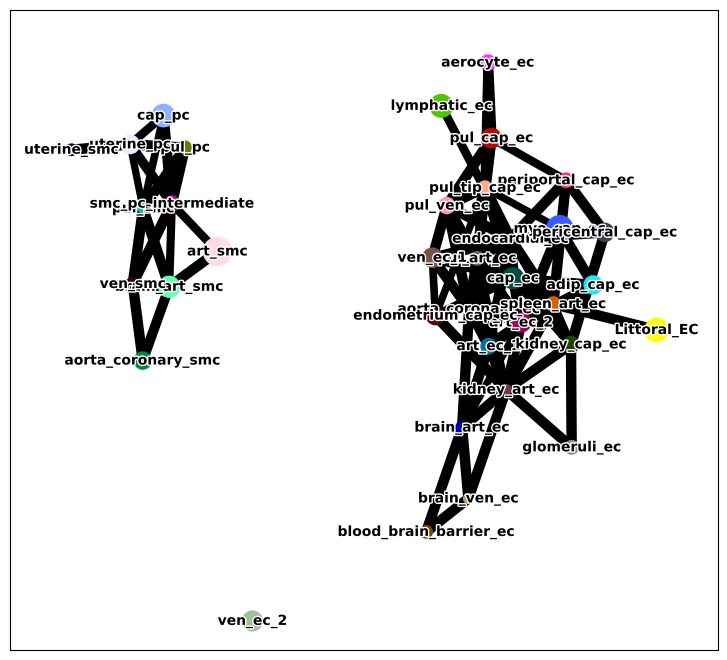

In [30]:
with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": 100, "figure.frameon": True, "figure.facecolor": "white"}):
    sc.pl.paga(ad_scenic, threshold=0.7, fontoutline=2)

In [31]:
sc.tl.umap(ad_scenic, init_pos="paga")

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


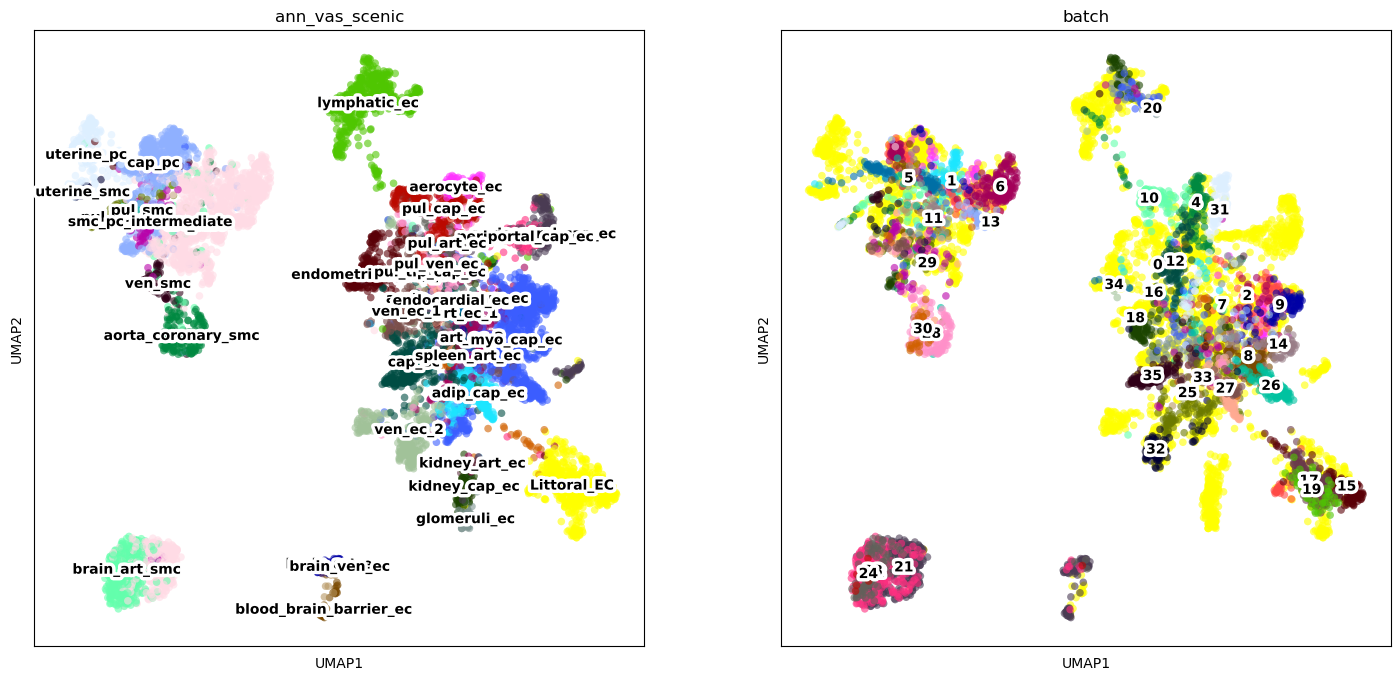

In [32]:
with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": 100, "figure.frameon": True, "figure.facecolor": "white"}):
    sc.pl.umap(
        ad_scenic, 
        color = [
            x
            for x in [annotation_col, "batch"]
            if x in ad_scenic.obs
        ], 
        legend_loc = "on data",
        ncols = 2,
        frameon = True, 
        legend_fontoutline = 5,
        size=120, 
        alpha = 0.6,
#         save="scenic_umap.png"
    )

## regulon specificity scores (RSS)

keep only positive regulators for RSS calculation

In [33]:
ad_scenic = ad_scenic[:,["(+)" in x for x in ad_scenic.var_names]]

In [34]:
auc_mtx = auc_mtx.loc[:,["(+)" in x for x in auc_mtx.columns]]

find regulons that are specific for each cell type

In [35]:
cats = sorted(ad_scenic.obs[annotation_col].unique().tolist())

In [36]:
rss_cellType = regulon_specificity_scores(auc_mtx, ad_scenic.obs[annotation_col])

In [37]:
rss_cellType

AHCTF1(+)    AHR(+)   AHRR(+)   ALX3(+)   ALX4(+)  \
blood_brain_barrier_ec   0.173457  0.172955  0.168140  0.167538  0.167445   
brain_ven_ec             0.169488  0.170587  0.168486  0.169018  0.168367   
art_smc                  0.251125  0.233176  0.186284  0.342687  0.364852   
smc_pc_intermediate      0.188068  0.181552  0.175404  0.180735  0.175014   
spleen_art_ec            0.202275  0.192186  0.194310  0.167716  0.172534   
ven_ec_2                 0.226264  0.257670  0.272429  0.167714  0.168087   
art_ec_2                 0.240075  0.224125  0.181696  0.169779  0.169819   
myo_cap_ec               0.290592  0.302796  0.196342  0.175144  0.169260   
art_ec_1                 0.207877  0.193404  0.174241  0.168393  0.168655   
cap_pc                   0.226853  0.216524  0.186004  0.183950  0.187233   
cap_ec                   0.230589  0.255071  0.311111  0.168205  0.178887   
Littoral_EC              0.271301  0.281679  0.338765  0.177288  0.171778   
lymphatic_ec             0.227948  0.232481  0.190733  0.174844  0.176538   
ven_ec_1                 0.231290  0.226871  0.290228  0.170825  0.171382   
adip_cap_ec              0.218029  0.231932  0.181276  0.168558  0.167445   
ven_smc                  0.177372  0.173783  0.176844  0.181421  0.175252   
brain_art_smc            0.199640  0.192446  0.177717  0.501340  0.491990   
aorta_coronary_smc       0.191009  0.177880  0.168313  0.181362  0.184927   
endocardial_ec           0.170604  0.171092  0.169963  0.171426  0.169789   
pul_tip_cap_ec           0.182050  0.184595  0.198176  0.169493  0.167996   
pul_cap_ec               0.215755  0.227884  0.192804  0.170102  0.168202   
kidney_art_ec            0.175330  0.172650  0.168745  0.168897  0.168923   
pul_ven_ec               0.192881  0.199283  0.190126  0.169539  0.169739   
pul_art_ec               0.183934  0.183863  0.172957  0.168188  0.167893   
pul_pc                   0.177169  0.176167  0.168751  0.170211  0.172226   
endometrium_cap_ec       0.188400  0.195891  0.186998  0.167751  0.169266   
aerocyte_ec              0.183427  0.188959  0.172248  0.180449  0.167445   
aorta_coronary_ec        0.173300  0.170963  0.167445  0.169659  0.170371   
pericentral_cap_ec       0.195565  0.211823  0.185809  0.169692  0.171567   
uterine_pc               0.183396  0.181129  0.175014  0.172986  0.169641   
periportal_cap_ec        0.183998  0.188612  0.173639  0.168962  0.168974   
pul_smc                  0.170435  0.170088  0.168286  0.176332  0.174929   
uterine_smc              0.171554  0.170349  0.168660  0.168010  0.168999   
kidney_cap_ec            0.189513  0.192347  0.180789  0.170256  0.173332   
glomeruli_ec             0.176008  0.180586  0.170394  0.168108  0.167619   
brain_art_ec             0.180914  0.176441  0.170828  0.170683  0.170534   

                        ARID3A(+)   ARNT(+)  ARNTL(+)   ATF1(+)   ATF2(+)  \
blood_brain_barrier_ec   0.176837  0.177704  0.172967  0.172095  0.178862   
brain_ven_ec             0.171032  0.171414  0.170539  0.169954  0.174390   
art_smc                  0.276901  0.305659  0.278623  0.308981  0.283569   
smc_pc_intermediate      0.189207  0.186776  0.186274  0.186207  0.185217   
spleen_art_ec            0.179374  0.188099  0.182864  0.184485  0.183864   
ven_ec_2                 0.204077  0.203367  0.218637  0.206909  0.287950   
art_ec_2                 0.199837  0.214543  0.213223  0.209922  0.216497   
myo_cap_ec               0.270126  0.303824  0.307457  0.301121  0.293430   
art_ec_1                 0.183103  0.190736  0.191317  0.187336  0.187339   
cap_pc                   0.262795  0.238060  0.243035  0.255662  0.229604   
cap_ec                   0.221243  0.222685  0.234550  0.228716  0.224071   
Littoral_EC              0.222477  0.251837  0.236740  0.242591  0.247172   
lymphatic_ec             0.231561  0.238321  0.239717  0.249355  0.225903   
ven_ec_1                 0.211763  0.213110  0.221919  0.213092  0.209386   
adip_cap_ec        

In [38]:
rss_cellType.to_csv('rss_vas_object_final.csv')

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


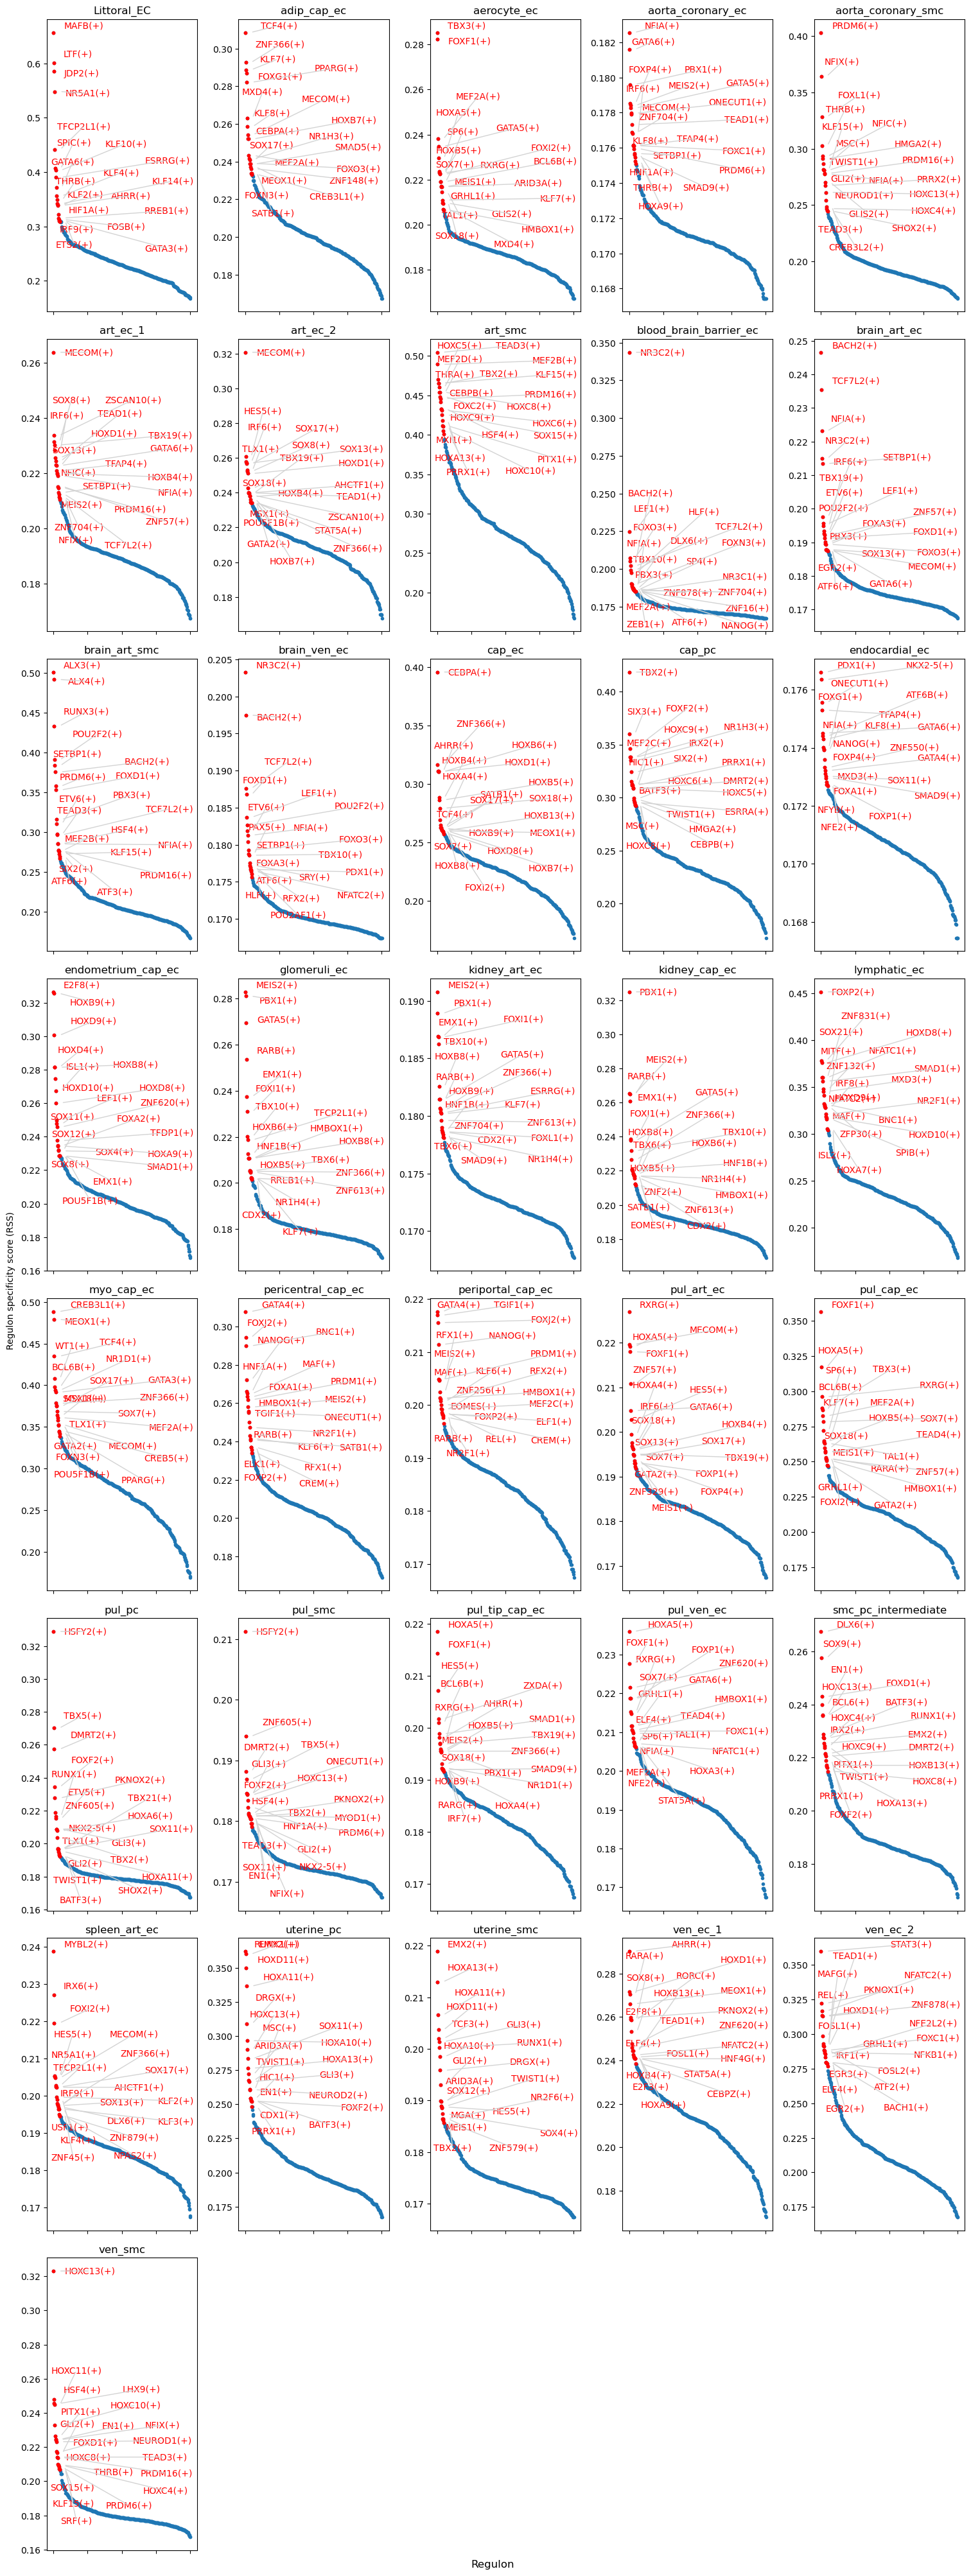

In [39]:
N = len(cats)
ncols = 5
nrows = math.ceil(N / ncols)

fig = plt.figure(figsize=(3*ncols, 5*nrows))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(nrows, ncols, num)
    plot_rss(rss_cellType, c, top_n=20, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='medium')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large',
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
# plt.savefig("../../SCENIC/tip_stalk_secretory_23Sep21_3/rss_top5.png", dpi=600, bbox_inches = "tight")
plt.show()

In [40]:
rss = pd.read_csv("/nfs/team205/ac65/vasculature/after_annotation/vascular_atlas/interactions/jhub_notebooks/scenic_analysis/rss_vas_object_final.csv")
rss.set_index('Unnamed: 0', inplace=True)
rss

AHCTF1(+)    AHR(+)   AHRR(+)   ALX3(+)   ALX4(+)  \
Unnamed: 0                                                                  
blood_brain_barrier_ec   0.173457  0.172955  0.168140  0.167538  0.167445   
brain_ven_ec             0.169488  0.170587  0.168486  0.169018  0.168367   
art_smc                  0.251125  0.233176  0.186284  0.342687  0.364852   
smc_pc_intermediate      0.188068  0.181552  0.175404  0.180735  0.175014   
spleen_art_ec            0.202275  0.192186  0.194310  0.167716  0.172534   
ven_ec_2                 0.226264  0.257670  0.272429  0.167714  0.168087   
art_ec_2                 0.240075  0.224125  0.181696  0.169779  0.169819   
myo_cap_ec               0.290592  0.302796  0.196342  0.175144  0.169260   
art_ec_1                 0.207877  0.193404  0.174241  0.168393  0.168655   
cap_pc                   0.226853  0.216524  0.186004  0.183950  0.187233   
cap_ec                   0.230589  0.255071  0.311111  0.168205  0.178887   
Littoral_EC              0.271301  0.281679  0.338765  0.177288  0.171778   
lymphatic_ec             0.227948  0.232481  0.190733  0.174844  0.176538   
ven_ec_1                 0.231290  0.226871  0.290228  0.170825  0.171382   
adip_cap_ec              0.218029  0.231932  0.181276  0.168558  0.167445   
ven_smc                  0.177372  0.173783  0.176844  0.181421  0.175252   
brain_art_smc            0.199640  0.192446  0.177717  0.501340  0.491990   
aorta_coronary_smc       0.191009  0.177880  0.168313  0.181362  0.184927   
endocardial_ec           0.170604  0.171092  0.169963  0.171426  0.169789   
pul_tip_cap_ec           0.182050  0.184595  0.198176  0.169493  0.167996   
pul_cap_ec               0.215755  0.227884  0.192804  0.170102  0.168202   
kidney_art_ec            0.175330  0.172650  0.168745  0.168897  0.168923   
pul_ven_ec               0.192881  0.199283  0.190126  0.169539  0.169739   
pul_art_ec               0.183934  0.183863  0.172957  0.168188  0.167893   
pul_pc                   0.177169  0.176167  0.168751  0.170211  0.172226   
endometrium_cap_ec       0.188400  0.195891  0.186998  0.167751  0.169266   
aerocyte_ec              0.183427  0.188959  0.172248  0.180449  0.167445   
aorta_coronary_ec        0.173300  0.170963  0.167445  0.169659  0.170371   
pericentral_cap_ec       0.195565  0.211823  0.185809  0.169692  0.171567   
uterine_pc               0.183396  0.181129  0.175014  0.172986  0.169641   
periportal_cap_ec        0.183998  0.188612  0.173639  0.168962  0.168974   
pul_smc                  0.170435  0.170088  0.168286  0.176332  0.174929   
uterine_smc              0.171554  0.170349  0.168660  0.168010  0.168999   
kidney_cap_ec            0.189513  0.192347  0.180789  0.170256  0.173332   
glomeruli_ec             0.176008  0.180586  0.170394  0.168108  0.167619   
brain_art_ec             0.180914  0.176441  0.170828  0.170683  0.170534   

                        ARID3A(+)   ARNT(+)  ARNTL(+)   ATF1(+)   ATF2(+)  \
Unnamed: 0                                                                  
blood_brain_barrier_ec   0.176837  0.177704  0.172967  0.172095  0.178862   
brain_ven_ec             0.171032  0.171414  0.170539  0.169954  0.174390   
art_smc                  0.276901  0.305659  0.278623  0.308981  0.283569   
smc_pc_intermediate      0.189207  0.186776  0.186274  0.186207  0.185217   
spleen_art_ec            0.179374  0.188099  0.182864  0.184485  0.183864   
ven_ec_2                 0.204077  0.203367  0.218637  0.206909  0.287950   
art_ec_2                 0.199837  0.214543  0.213223  0.209922  0.216497   
myo_cap_ec               0.270126  0.303824  0.307457  0.301121  0.293430   
art_ec_1                 0.183103  0.190736  0.191317  0.187336  0.187339   
cap_pc                   0.262795  0.238060  0.243035  0.255662  0.229604   
cap_ec                   0.221243  0.222685  0.234550  0.228716  0.224071   
Littoral_EC              0.222477  0.251837  0.236740  0.242591  0.247172   
lymphatic_ec       

In [41]:
rss = rss.T
rss = rss[rss.index.str.endswith("(+)")]
rss

Unnamed: 0  blood_brain_barrier_ec  brain_ven_ec   art_smc  \
AHCTF1(+)                 0.173457      0.169488  0.251125   
AHR(+)                    0.172955      0.170587  0.233176   
AHRR(+)                   0.168140      0.168486  0.186284   
ALX3(+)                   0.167538      0.169018  0.342687   
ALX4(+)                   0.167445      0.168367  0.364852   
...                            ...           ...       ...   
ZNF878(+)                 0.186588      0.171790  0.233035   
ZNF879(+)                 0.183828      0.169915  0.243765   
ZNF91(+)                  0.177974      0.170262  0.279537   
ZSCAN10(+)                0.170219      0.170349  0.271665   
ZXDA(+)                   0.170210      0.170976  0.247838   

Unnamed: 0  smc_pc_intermediate  spleen_art_ec  ven_ec_2  art_ec_2  \
AHCTF1(+)              0.188068       0.202275  0.226264  0.240075   
AHR(+)                 0.181552       0.192186  0.257670  0.224125   
AHRR(+)                0.175404       0.194310  0.272429  0.181696   
ALX3(+)                0.180735       0.167716  0.167714  0.169779   
ALX4(+)                0.175014       0.172534  0.168087  0.169819   
...                         ...            ...       ...       ...   
ZNF878(+)              0.194971       0.187795  0.313011  0.191330   
ZNF879(+)              0.189144       0.194583  0.208583  0.217840   
ZNF91(+)               0.184234       0.185914  0.208085  0.217202   
ZSCAN10(+)             0.196282       0.190462  0.231434  0.238402   
ZXDA(+)                0.177732       0.185731  0.198002  0.215047   

Unnamed: 0  myo_cap_ec  art_ec_1    cap_pc  ...  aerocyte_ec  \
AHCTF1(+)     0.290592  0.207877  0.226853  ...     0.183427   
AHR(+)        0.302796  0.193404  0.216524  ...     0.188959   
AHRR(+)       0.196342  0.174241  0.186004  ...     0.172248   
ALX3(+)       0.175144  0.168393  0.183950  ...     0.180449   
ALX4(+)       0.169260  0.168655  0.187233  ...     0.167445   
...                ...       ...       ...  ...          ...   
ZNF878(+)     0.256093  0.174763  0.191578  ...     0.174595   
ZNF879(+)     0.252203  0.187191  0.223002  ...     0.179200   
ZNF91(+)      0.305943  0.190285  0.246508  ...     0.192705   
ZSCAN10(+)    0.237455  0.233573  0.220776  ...     0.175101   
ZXDA(+)       0.267261  0.187928  0.231882  ...     0.182845   

Unnamed: 0  aorta_coronary_ec  pericentral_cap_ec  uterine_pc  \
AHCTF1(+)            0.173300            0.195565    0.183396   
AHR(+)               0.170963            0.211823    0.181129   
AHRR(+)              0.167445            0.185809    0.175014   
ALX3(+)              0.169659            0.169692    0.172986   
ALX4(+)              0.170371            0.171567    0.169641   
...                       ...                 ...         ...   
ZNF878(+)            0.169146            0.192249    0.188143   
ZNF879(+)            0.170624            0.196039    0.204027   
ZNF91(+)             0.171110            0.208733    0.192877   
ZSCAN10(+)           0.174392            0.181129    0.194084   
ZXDA(+)              0.169192            0.223019    0.200883   

Unnamed: 0  periportal_cap_ec   pul_smc  uterine_smc  kidney_cap_ec  \
AHCTF1(+)            0.183998  0.170435     0.171554       0.189513   
AHR(+)               0.188612  0.170088     0.170349       0.192347   
AHRR(+)              0.173639  0.168286     0.168660       0.180789   
ALX3(+)              0.168962  0.176332     0.168010       0.170256   
ALX4(+)              0.168974  0.174929     0.168999       0.173332   
...                       ...       ...          ...            ...   
ZNF878(+)            0.186673  0.168821     0.170409       0.181756   
ZNF879(+)            0.188777  0.172898     0.174987       0.188855   
ZNF91(+)             0.186916  0.171385     0.174157       0.200598   
ZSCAN10(+)           0.177443  0.171584     0.175635       0.184298   
ZXDA(+)              0.189597  0.171906     0.170194       0.196583   

Unnamed: 0 

In [42]:
rss.to_csv('/nfs/team205/ac65/vasculature/after_annotation/vascular_atlas/interactions/jhub_notebooks/scenic_analysis/rss_vas_object_final_T.csv')

# filtered TFs for each comparment

1. remove TF < 10% cells for each compartment
2. remove TF = 0 expression for each compartment
3. radar plot

In [43]:
rss

Unnamed: 0  blood_brain_barrier_ec  brain_ven_ec   art_smc  \
AHCTF1(+)                 0.173457      0.169488  0.251125   
AHR(+)                    0.172955      0.170587  0.233176   
AHRR(+)                   0.168140      0.168486  0.186284   
ALX3(+)                   0.167538      0.169018  0.342687   
ALX4(+)                   0.167445      0.168367  0.364852   
...                            ...           ...       ...   
ZNF878(+)                 0.186588      0.171790  0.233035   
ZNF879(+)                 0.183828      0.169915  0.243765   
ZNF91(+)                  0.177974      0.170262  0.279537   
ZSCAN10(+)                0.170219      0.170349  0.271665   
ZXDA(+)                   0.170210      0.170976  0.247838   

Unnamed: 0  smc_pc_intermediate  spleen_art_ec  ven_ec_2  art_ec_2  \
AHCTF1(+)              0.188068       0.202275  0.226264  0.240075   
AHR(+)                 0.181552       0.192186  0.257670  0.224125   
AHRR(+)                0.175404       0.194310  0.272429  0.181696   
ALX3(+)                0.180735       0.167716  0.167714  0.169779   
ALX4(+)                0.175014       0.172534  0.168087  0.169819   
...                         ...            ...       ...       ...   
ZNF878(+)              0.194971       0.187795  0.313011  0.191330   
ZNF879(+)              0.189144       0.194583  0.208583  0.217840   
ZNF91(+)               0.184234       0.185914  0.208085  0.217202   
ZSCAN10(+)             0.196282       0.190462  0.231434  0.238402   
ZXDA(+)                0.177732       0.185731  0.198002  0.215047   

Unnamed: 0  myo_cap_ec  art_ec_1    cap_pc  ...  aerocyte_ec  \
AHCTF1(+)     0.290592  0.207877  0.226853  ...     0.183427   
AHR(+)        0.302796  0.193404  0.216524  ...     0.188959   
AHRR(+)       0.196342  0.174241  0.186004  ...     0.172248   
ALX3(+)       0.175144  0.168393  0.183950  ...     0.180449   
ALX4(+)       0.169260  0.168655  0.187233  ...     0.167445   
...                ...       ...       ...  ...          ...   
ZNF878(+)     0.256093  0.174763  0.191578  ...     0.174595   
ZNF879(+)     0.252203  0.187191  0.223002  ...     0.179200   
ZNF91(+)      0.305943  0.190285  0.246508  ...     0.192705   
ZSCAN10(+)    0.237455  0.233573  0.220776  ...     0.175101   
ZXDA(+)       0.267261  0.187928  0.231882  ...     0.182845   

Unnamed: 0  aorta_coronary_ec  pericentral_cap_ec  uterine_pc  \
AHCTF1(+)            0.173300            0.195565    0.183396   
AHR(+)               0.170963            0.211823    0.181129   
AHRR(+)              0.167445            0.185809    0.175014   
ALX3(+)              0.169659            0.169692    0.172986   
ALX4(+)              0.170371            0.171567    0.169641   
...                       ...                 ...         ...   
ZNF878(+)            0.169146            0.192249    0.188143   
ZNF879(+)            0.170624            0.196039    0.204027   
ZNF91(+)             0.171110            0.208733    0.192877   
ZSCAN10(+)           0.174392            0.181129    0.194084   
ZXDA(+)              0.169192            0.223019    0.200883   

Unnamed: 0  periportal_cap_ec   pul_smc  uterine_smc  kidney_cap_ec  \
AHCTF1(+)            0.183998  0.170435     0.171554       0.189513   
AHR(+)               0.188612  0.170088     0.170349       0.192347   
AHRR(+)              0.173639  0.168286     0.168660       0.180789   
ALX3(+)              0.168962  0.176332     0.168010       0.170256   
ALX4(+)              0.168974  0.174929     0.168999       0.173332   
...                       ...       ...          ...            ...   
ZNF878(+)            0.186673  0.168821     0.170409       0.181756   
ZNF879(+)            0.188777  0.172898     0.174987       0.188855   
ZNF91(+)             0.186916  0.171385     0.174157       0.200598   
ZSCAN10(+)           0.177443  0.171584     0.175635       0.184298   
ZXDA(+)              0.189597  0.171906     0.170194       0.196583   

Unnamed: 0 

In [44]:
rss.index

Index(['AHCTF1(+)', 'AHR(+)', 'AHRR(+)', 'ALX3(+)', 'ALX4(+)', 'ARID3A(+)',
       'ARNT(+)', 'ARNTL(+)', 'ATF1(+)', 'ATF2(+)',
       ...
       'ZNF704(+)', 'ZNF71(+)', 'ZNF76(+)', 'ZNF831(+)', 'ZNF846(+)',
       'ZNF878(+)', 'ZNF879(+)', 'ZNF91(+)', 'ZSCAN10(+)', 'ZXDA(+)'],
      dtype='object', length=402)

In [45]:
# generate a gene list of TFs by removing (+)
cap_TFs = [index[:-3] for index in rss.index]
len(cap_TFs)

402

In [46]:
# create a vas adata containing only TFs
ad_TFs = ad[:, cap_TFs]
ad_TFs.X.shape

(66623, 402)

In [47]:
dp = sc.pl.dotplot(ad_TFs, var_names = cap_TFs, groupby = "ann_vas_scenic", return_fig=True)

In [48]:
dp.dot_size_df

AHCTF1       AHR      AHRR      ALX3      ALX4  \
ann_vas_scenic                                                             
Littoral_EC             0.395459  0.550877  0.056760  0.000826  0.000206   
adip_cap_ec             0.304949  0.539649  0.003193  0.002129  0.000000   
aerocyte_ec             0.064076  0.203782  0.006303  0.000000  0.000000   
aorta_coronary_ec       0.246377  0.456522  0.000000  0.000000  0.000000   
aorta_coronary_smc      0.462012  0.401095  0.000684  0.004791  0.000000   
art_ec_1                0.332168  0.320513  0.003497  0.000000  0.001166   
art_ec_2                0.288939  0.360271  0.004966  0.000903  0.000000   
art_smc                 0.130010  0.106811  0.005528  0.027246  0.020039   
blood_brain_barrier_ec  0.377717  0.173913  0.016304  0.000000  0.002717   
brain_art_ec            0.389671  0.481221  0.046948  0.002347  0.009390   
brain_art_smc           0.159202  0.235890  0.020552  0.100613  0.070552   
brain_ven_ec            0.244755  0.538462  0.125874  0.000000  0.006993   
cap_ec                  0.247151  0.538692  0.044091  0.000600  0.000000   
cap_pc                  0.085023  0.081847  0.005131  0.000733  0.001222   
endocardial_ec          0.187500  0.156250  0.000000  0.000000  0.000000   
endometrium_cap_ec      0.121368  0.263818  0.003989  0.001709  0.000000   
glomeruli_ec            0.072250  0.178982  0.004926  0.001642  0.000000   
kidney_art_ec           0.136170  0.306383  0.008511  0.000000  0.000000   
kidney_cap_ec           0.097470  0.185567  0.002812  0.002812  0.000000   
lymphatic_ec            0.139650  0.239839  0.000945  0.000236  0.000000   
myo_cap_ec              0.128411  0.222647  0.001530  0.000383  0.000128   
pericentral_cap_ec      0.142067  0.237148  0.001658  0.000000  0.000000   
periportal_cap_ec       0.174242  0.304545  0.003030  0.000000  0.000000   
pul_art_ec              0.115318  0.285714  0.015491  0.000000  0.000000   
pul_cap_ec              0.083443  0.276680  0.018006  0.000439  0.000000   
pul_pc                  0.097285  0.031674  0.004525  0.000000  0.000000   
pul_smc                 0.103896  0.084416  0.000000  0.012987  0.006494   
pul_tip_cap_ec          0.126736  0.302083  0.050347  0.000000  0.000000   
pul_ven_ec              0.147745  0.411353  0.010886  0.000000  0.000000   
smc_pc_intermediate     0.145877  0.224101  0.004228  0.008457  0.006342   
spleen_art_ec           0.397143  0.394286  0.051429  0.000000  0.000000   
uterine_pc              0.077796  0.114533  0.012966  0.001080  0.002161   
uterine_smc             0.178571  0.293651  0.011905  0.003968  0.023810   
ven_ec_1                0.185307  0.331774  0.038839  0.000000  0.000000   
ven_ec_2                0.299366  0.735924  0.033703  0.001190  0.000000   
ven_smc                 0.232824  0.183206  0.000000  0.013359  0.000000   

                          ARID3A      ARNT     ARNTL      ATF1      ATF2  ...  \
ann_vas_scenic                                                            ...   
Littoral_EC             0.032611  0.162642  0.069969  0.187410  0.270382  ...   
adip_cap_ec             0.037786  0.198510  0.137307  0.182012  0.283662  ...   
aerocyte_ec             0.080882  0.072479  0.040966  0.064076  0.088235  ...   
aorta_coronary_ec       0.021739  0.289855  0.130435  0.231884  0.282609  ...   
aorta_coronary_smc      0.021218  0.334018  0.160164  0.284052  0.352498  ...   
art_ec_1                0.013986  0.135198  0.067599  0.130536  0.192308  ...   
art_ec_2                0.018510  0.112867  0.069977  0.134989  0.199097  ...   
art_smc                 0.027641  0.113031  0.065844  0.142251  0.193386  ...   
blood_brain_barrier_ec  0.122283  0.347826  0.073370  0.198370  0.483696  ...   
brain_art_ec            0.018779  0.183099  0.082160  0.185446  0.434272  ...   
brain_art_smc           0.006442  0.142331  0.058282  0.184969  0.315644  ...   
brain_ven_ec            0.048951  0.223776  0.223776  0.279720  0.531469  ...   
cap

In [49]:
dp.dot_color_df

AHCTF1       AHR      AHRR      ALX3      ALX4  \
ann_vas_scenic                                                             
Littoral_EC             0.489861  0.814808  0.055412  0.000690  0.000519   
adip_cap_ec             0.307017  0.667909  0.002685  0.001519  0.000000   
aerocyte_ec             0.091682  0.302655  0.012328  0.000000  0.000000   
aorta_coronary_ec       0.225664  0.454128  0.000000  0.000000  0.000000   
aorta_coronary_smc      0.315650  0.279414  0.000088  0.002748  0.000000   
art_ec_1                0.394950  0.378476  0.002866  0.000000  0.000783   
art_ec_2                0.357076  0.497784  0.005506  0.000695  0.000000   
art_smc                 0.131728  0.109353  0.004602  0.025626  0.018401   
blood_brain_barrier_ec  0.384290  0.154855  0.011686  0.000000  0.000359   
brain_art_ec            0.495080  0.628972  0.038378  0.002027  0.007241   
brain_art_smc           0.177799  0.285759  0.023986  0.102921  0.081139   
brain_ven_ec            0.191345  0.586819  0.067062  0.000000  0.003530   
cap_ec                  0.266599  0.743112  0.044905  0.000721  0.000000   
cap_pc                  0.105181  0.099996  0.006856  0.000661  0.001470   
endocardial_ec          0.196376  0.162807  0.000000  0.000000  0.000000   
endometrium_cap_ec      0.097745  0.268600  0.001413  0.001288  0.000000   
glomeruli_ec            0.092750  0.250965  0.005227  0.002188  0.000000   
kidney_art_ec           0.153591  0.423063  0.011131  0.000000  0.000000   
kidney_cap_ec           0.143916  0.290960  0.005251  0.005267  0.000000   
lymphatic_ec            0.154330  0.291383  0.001552  0.000376  0.000000   
myo_cap_ec              0.164247  0.308918  0.002116  0.000397  0.000136   
pericentral_cap_ec      0.172645  0.323369  0.002423  0.000000  0.000000   
periportal_cap_ec       0.184899  0.348368  0.002396  0.000000  0.000000   
pul_art_ec              0.147425  0.388826  0.013379  0.000000  0.000000   
pul_cap_ec              0.112534  0.431808  0.020007  0.000532  0.000000   
pul_pc                  0.136449  0.043034  0.006951  0.000000  0.000000   
pul_smc                 0.125559  0.100934  0.000000  0.017620  0.010512   
pul_tip_cap_ec          0.145563  0.416073  0.064937  0.000000  0.000000   
pul_ven_ec              0.148205  0.504265  0.009988  0.000000  0.000000   
smc_pc_intermediate     0.161996  0.240806  0.003700  0.006943  0.006206   
spleen_art_ec           0.575184  0.574754  0.065816  0.000000  0.000000   
uterine_pc              0.073290  0.115489  0.012036  0.000909  0.002199   
uterine_smc             0.148422  0.283701  0.008761  0.003090  0.020831   
ven_ec_1                0.217415  0.432413  0.047578  0.000000  0.000000   
ven_ec_2                0.234197  0.892151  0.018953  0.000917  0.000000   
ven_smc                 0.196001  0.147211  0.000000  0.009996  0.000000   

                          ARID3A      ARNT     ARNTL      ATF1      ATF2  ...  \
ann_vas_scenic                                                            ...   
Littoral_EC             0.030545  0.167476  0.064360  0.194670  0.294346  ...   
adip_cap_ec             0.027797  0.179986  0.118125  0.145817  0.279342  ...   
aerocyte_ec             0.133101  0.110858  0.059253  0.096927  0.135446  ...   
aorta_coronary_ec       0.016321  0.229356  0.084560  0.173617  0.268833  ...   
aorta_coronary_smc      0.006702  0.200017  0.082392  0.161250  0.210988  ...   
art_ec_1                0.011047  0.134454  0.064996  0.126624  0.194139  ...   
art_ec_2                0.018387  0.116570  0.070068  0.140969  0.224459  ...   
art_smc                 0.027651  0.111385  0.065598  0.149140  0.201223  ...   
blood_brain_barrier_ec  0.108750  0.335525  0.070195  0.194343  0.540980  ...   
brain_art_ec            0.013517  0.176661  0.069561  0.169895  0.553568  ...   
brain_art_smc           0.005902  0.154281  0.060309  0.207746  0.403412  ...   
brain_ven_ec            0.020357  0.177193  0.185266  0.223648  0.594616  ...   
cap

In [50]:
min_fraction = 0.1
min_expression = 0.0

# Initialize an empty list to store the results
filtered_rss = {}

# Loop through the rows of the DataFrames
for cell_type in dp.dot_size_df.index:
    # Apply filtering for dot_size_df
    dp.dot_size_filtered = dp.dot_size_df.loc[cell_type][dp.dot_size_df.loc[cell_type] >= min_fraction]

    # Apply filtering for dot_color_df
    dp.dot_color_filtered = dp.dot_color_df.loc[cell_type][dp.dot_color_df.loc[cell_type] > min_expression]

    # Find the intersection of the two filtered Series
    intersection = dp.dot_size_filtered.index.intersection(dp.dot_color_filtered.index)

    # Convert the intersection to a list with '(+)' appended to each gene name
    intersection_list = [gene + '(+)' for gene in intersection]

    # Add the result to the list of filtered results
    filtered_rss[cell_type] = intersection_list

lengths = {cell_type: len(genes) for cell_type, genes in filtered_rss.items()}
lengths

{'Littoral_EC': 180,
 'adip_cap_ec': 188,
 'aerocyte_ec': 105,
 'aorta_coronary_ec': 200,
 'aorta_coronary_smc': 210,
 'art_ec_1': 160,
 'art_ec_2': 158,
 'art_smc': 134,
 'blood_brain_barrier_ec': 188,
 'brain_art_ec': 177,
 'brain_art_smc': 144,
 'brain_ven_ec': 188,
 'cap_ec': 184,
 'cap_pc': 101,
 'endocardial_ec': 141,
 'endometrium_cap_ec': 169,
 'glomeruli_ec': 112,
 'kidney_art_ec': 135,
 'kidney_cap_ec': 105,
 'lymphatic_ec': 163,
 'myo_cap_ec': 120,
 'pericentral_cap_ec': 130,
 'periportal_cap_ec': 151,
 'pul_art_ec': 144,
 'pul_cap_ec': 119,
 'pul_pc': 105,
 'pul_smc': 139,
 'pul_tip_cap_ec': 134,
 'pul_ven_ec': 153,
 'smc_pc_intermediate': 153,
 'spleen_art_ec': 157,
 'uterine_pc': 144,
 'uterine_smc': 187,
 'ven_ec_1': 149,
 'ven_ec_2': 205,
 'ven_smc': 183}

In [51]:
filtered_rss.keys()

dict_keys(['Littoral_EC', 'adip_cap_ec', 'aerocyte_ec', 'aorta_coronary_ec', 'aorta_coronary_smc', 'art_ec_1', 'art_ec_2', 'art_smc', 'blood_brain_barrier_ec', 'brain_art_ec', 'brain_art_smc', 'brain_ven_ec', 'cap_ec', 'cap_pc', 'endocardial_ec', 'endometrium_cap_ec', 'glomeruli_ec', 'kidney_art_ec', 'kidney_cap_ec', 'lymphatic_ec', 'myo_cap_ec', 'pericentral_cap_ec', 'periportal_cap_ec', 'pul_art_ec', 'pul_cap_ec', 'pul_pc', 'pul_smc', 'pul_tip_cap_ec', 'pul_ven_ec', 'smc_pc_intermediate', 'spleen_art_ec', 'uterine_pc', 'uterine_smc', 'ven_ec_1', 'ven_ec_2', 'ven_smc'])

# LITTORAL, SPLEEN ART EC, ENDOCARDIUM PLOTS

Index(['NR3C2(+)', 'LEF1(+)', 'FOXO3(+)', 'BACH2(+)', 'TCF7L2(+)'], dtype='object')


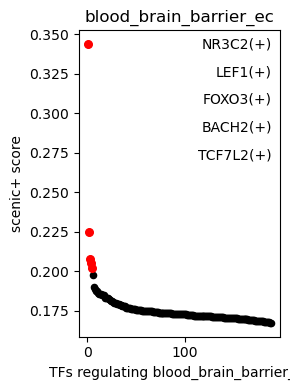

Index(['NR3C2(+)', 'BACH2(+)', 'TCF7L2(+)', 'LEF1(+)', 'POU2F2(+)'], dtype='object')


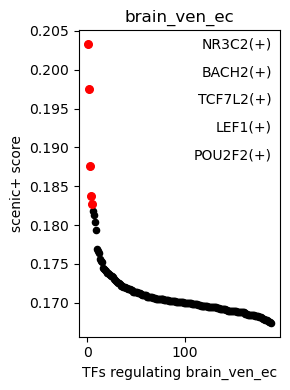

Index(['TEAD3(+)', 'TBX2(+)', 'MEF2D(+)', 'THRA(+)', 'FOXC2(+)'], dtype='object')


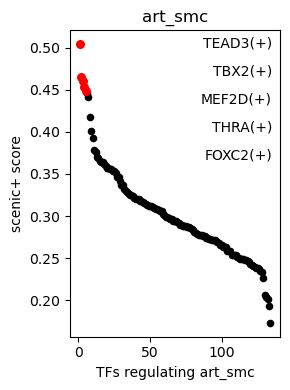

Index(['BCL6(+)', 'BATF3(+)', 'RUNX1(+)', 'EMX2(+)', 'IRX2(+)'], dtype='object')


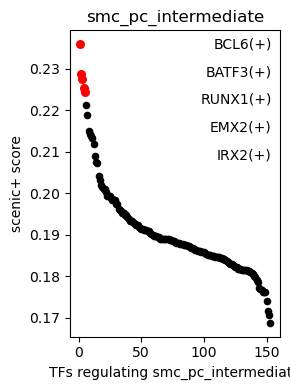

Index(['MYBL2(+)', 'IRX6(+)', 'NR5A1(+)', 'MECOM(+)', 'SOX17(+)'], dtype='object')


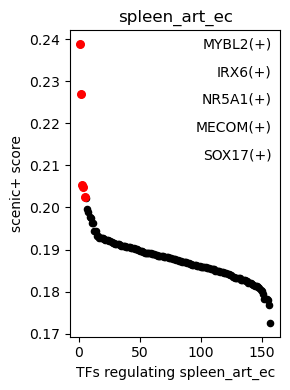

Index(['STAT3(+)', 'PKNOX1(+)', 'NFATC2(+)', 'HOXD1(+)', 'TEAD1(+)'], dtype='object')


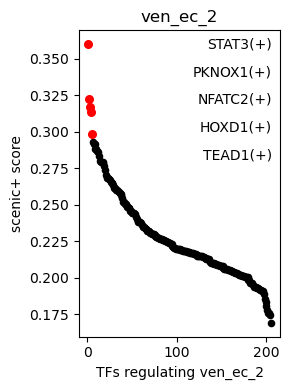

Index(['MECOM(+)', 'IRF6(+)', 'SOX13(+)', 'SOX17(+)', 'SOX18(+)'], dtype='object')


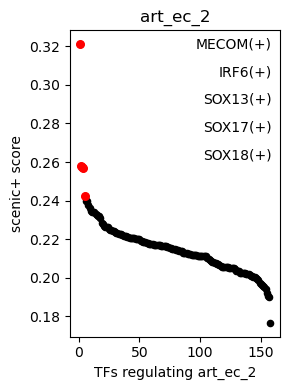

Index(['CREB3L1(+)', 'MEOX1(+)', 'TCF4(+)', 'BCL6B(+)', 'GATA3(+)'], dtype='object')


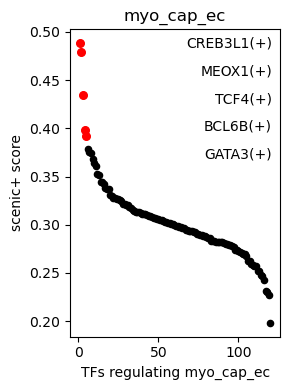

Index(['MECOM(+)', 'IRF6(+)', 'TEAD1(+)', 'SOX13(+)', 'GATA6(+)'], dtype='object')


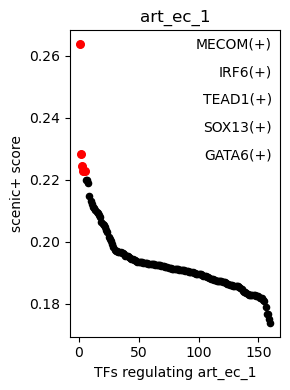

Index(['TBX2(+)', 'NR1H3(+)', 'MEF2C(+)', 'PRRX1(+)', 'HIC1(+)'], dtype='object')


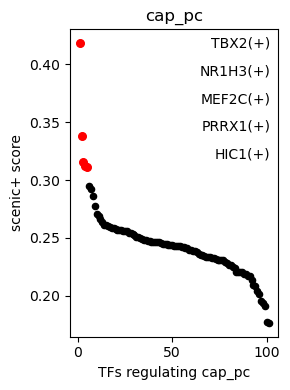

Index(['ZNF366(+)', 'HOXB6(+)', 'HOXB4(+)', 'HOXB5(+)', 'SOX18(+)'], dtype='object')


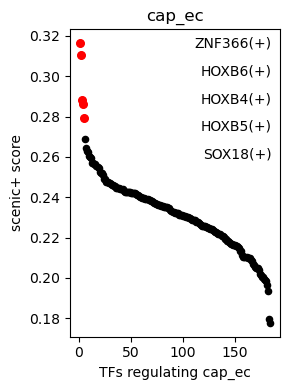

Index(['MAFB(+)', 'LTF(+)', 'JDP2(+)', 'NR5A1(+)', 'KLF10(+)'], dtype='object')


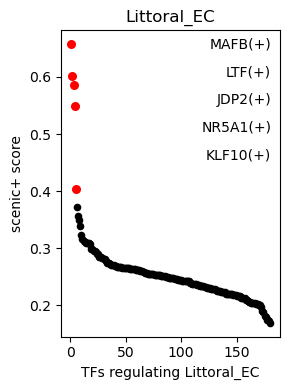

Index(['FOXP2(+)', 'HOXD8(+)', 'NFATC1(+)', 'SMAD1(+)', 'NFATC2(+)'], dtype='object')


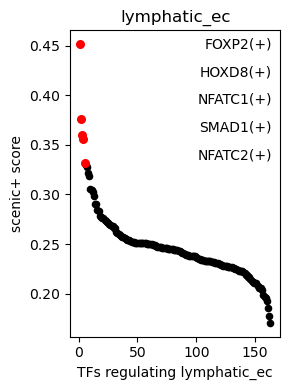

Index(['RARA(+)', 'MEOX1(+)', 'TEAD1(+)', 'NFATC2(+)', 'FOSL1(+)'], dtype='object')


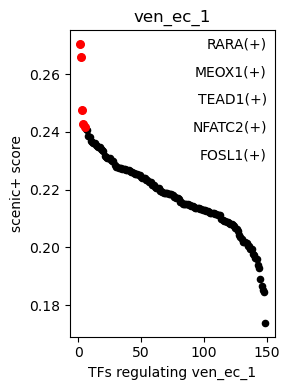

Index(['TCF4(+)', 'ZNF366(+)', 'KLF7(+)', 'PPARG(+)', 'MXD4(+)'], dtype='object')


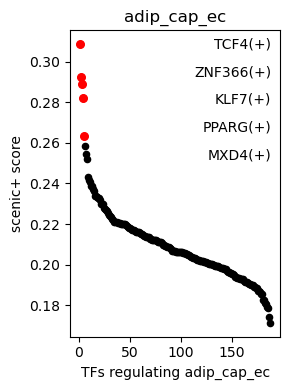

Index(['HSF4(+)', 'HOXC10(+)', 'NFIX(+)', 'TEAD3(+)', 'PRDM16(+)'], dtype='object')


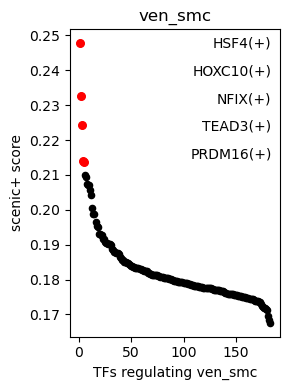

Index(['ALX3(+)', 'RUNX3(+)', 'POU2F2(+)', 'SETBP1(+)', 'BACH2(+)'], dtype='object')


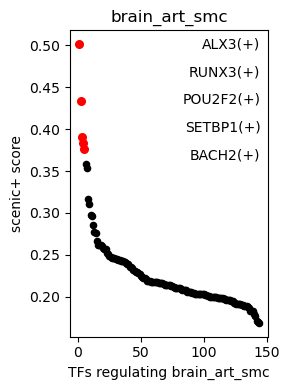

Index(['PRDM6(+)', 'NFIX(+)', 'FOXL1(+)', 'THRB(+)', 'NFIC(+)'], dtype='object')


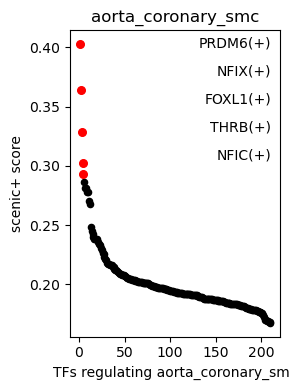

Index(['GATA6(+)', 'ATF6B(+)', 'NFIA(+)', 'GATA4(+)', 'SMAD9(+)'], dtype='object')


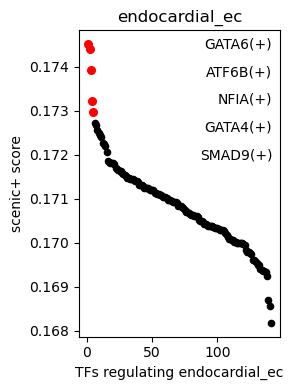

Index(['HOXA5(+)', 'FOXF1(+)', 'BCL6B(+)', 'SMAD1(+)', 'MEIS2(+)'], dtype='object')


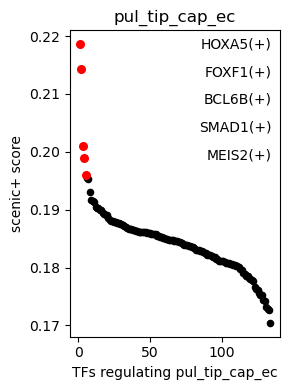

Index(['FOXF1(+)', 'HOXA5(+)', 'TBX3(+)', 'SP6(+)', 'MEF2A(+)'], dtype='object')


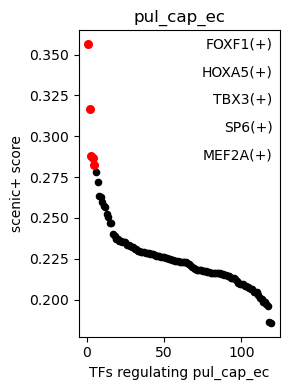

Index(['MEIS2(+)', 'PBX1(+)', 'RARB(+)', 'ZNF366(+)', 'KLF7(+)'], dtype='object')


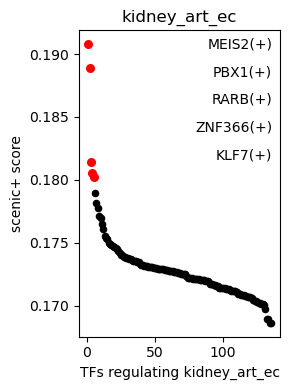

Index(['HOXA5(+)', 'FOXF1(+)', 'FOXP1(+)', 'GATA6(+)', 'SOX7(+)'], dtype='object')


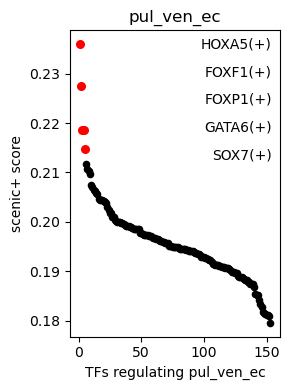

Index(['RXRG(+)', 'MECOM(+)', 'HOXA5(+)', 'FOXF1(+)', 'GATA6(+)'], dtype='object')


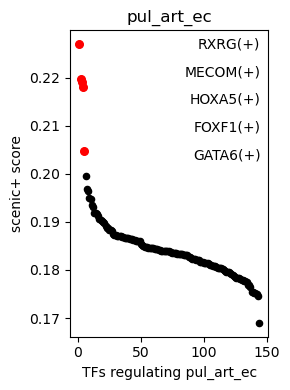

Index(['TBX5(+)', 'FOXF2(+)', 'RUNX1(+)', 'ETV5(+)', 'TBX2(+)'], dtype='object')


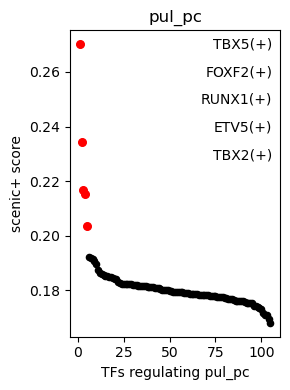

Index(['HOXD9(+)', 'HOXD10(+)', 'HOXD8(+)', 'LEF1(+)', 'TFDP1(+)'], dtype='object')


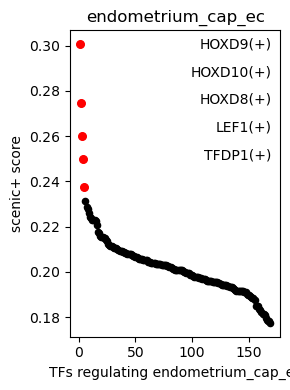

Index(['TBX3(+)', 'FOXF1(+)', 'MEF2A(+)', 'HOXB5(+)', 'SOX7(+)'], dtype='object')


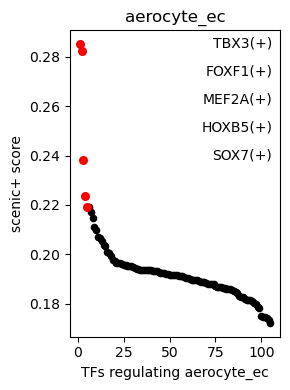

Index(['NFIA(+)', 'GATA6(+)', 'PBX1(+)', 'MEIS2(+)', 'MECOM(+)'], dtype='object')


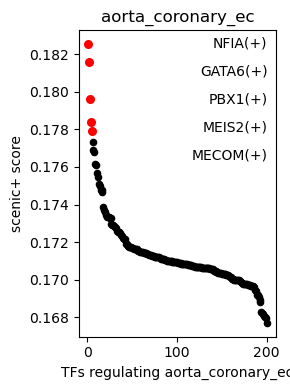

Index(['GATA4(+)', 'FOXJ2(+)', 'MAF(+)', 'PRDM1(+)', 'MEIS2(+)'], dtype='object')


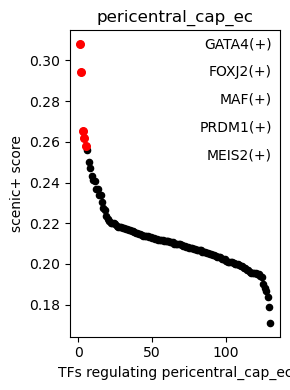

Index(['RUNX1(+)', 'EMX2(+)', 'HOXD11(+)', 'HOXA11(+)', 'HOXA10(+)'], dtype='object')


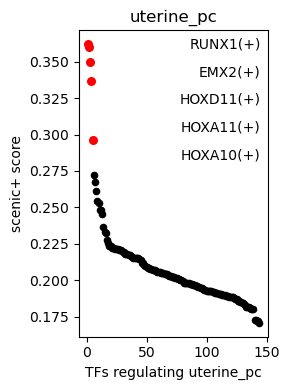

Index(['GATA4(+)', 'TGIF1(+)', 'FOXJ2(+)', 'PRDM1(+)', 'MEIS2(+)'], dtype='object')


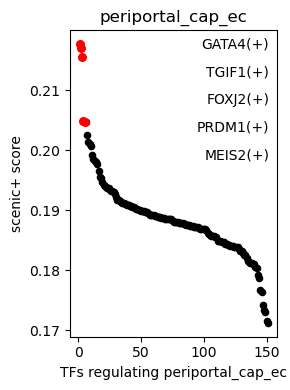

Index(['TBX5(+)', 'FOXF2(+)', 'GLI3(+)', 'TBX2(+)', 'TEAD3(+)'], dtype='object')


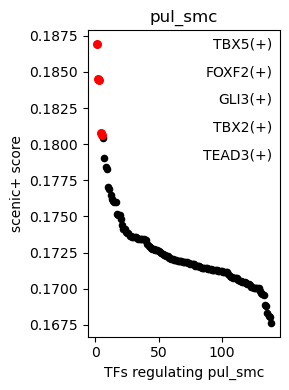

Index(['EMX2(+)', 'HOXA11(+)', 'HOXD11(+)', 'TCF3(+)', 'GLI3(+)'], dtype='object')


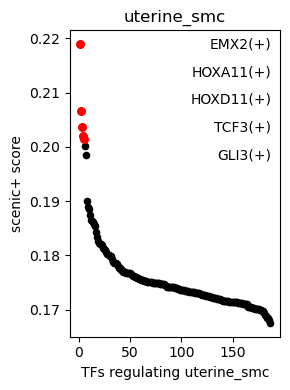

Index(['PBX1(+)', 'MEIS2(+)', 'RARB(+)', 'ZNF366(+)', 'HOXB6(+)'], dtype='object')


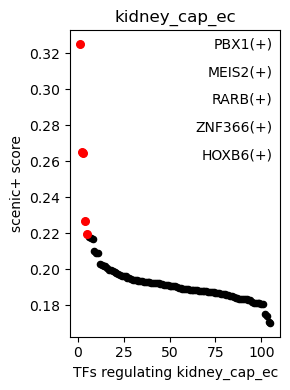

Index(['MEIS2(+)', 'PBX1(+)', 'GATA5(+)', 'RARB(+)', 'HOXB6(+)'], dtype='object')


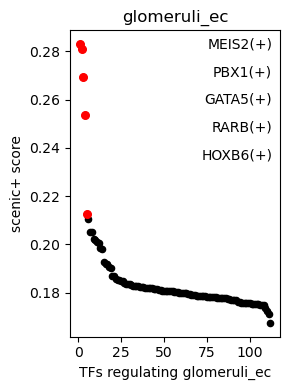

Index(['BACH2(+)', 'TCF7L2(+)', 'NFIA(+)', 'NR3C2(+)', 'SETBP1(+)'], dtype='object')


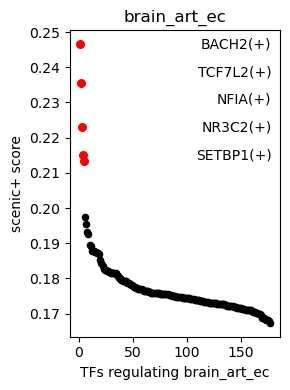

In [52]:
for column_name in rss.columns:
    # Get the values for the specific column (cell type)
    temp = rss[rss.index.isin(filtered_rss[column_name])]
    values = temp[column_name]
    sorted_values = values.sort_values(ascending=False)
    
    # showing top 5 TFs
    top_5_values = sorted_values.head(5)
    top_5_indices = top_5_values.index
    print(top_5_indices)
    
    # plot the scatter plot for all values and top TFs
    plt.figure(figsize=(3, 4))  # Set the figure size
    plt.scatter(range(1, len(values) + 1), sorted_values, color = 'black', label=column_name, s = 20) # Plot all TF values
    plt.scatter(range(1,6), top_5_values, color='red', marker='o', s=30) # Plot the top TF values and highlight in another colour
    
    #for i, txt in enumerate(top_5_indices):
    #    plt.annotate(txt, (i + 10, top_5_values.iloc[i]), ha='left', va='center')
    value_range = max(sorted_values) - min(sorted_values)
    label_interval = value_range / 10
    label_y_positions = [max(sorted_values) - i * label_interval for i in range(len(top_5_indices))]
    
    for i, label in enumerate(top_5_indices):
        plt.text(len(values) + 1, label_y_positions[i], label, ha='right', va='center')
    
    plt.xlabel('TFs regulating {}'.format(column_name))
    plt.ylabel('scenic+ score')
    plt.title(column_name)
    plt.grid(False)
    
    plt.savefig('top_6_TFs_{}.png'.format(column_name), bbox_inches = 'tight', pad_inches = 0.1)
 
    plt.show()

# plot DE target genes for each DE TF

In [53]:
sc.tl.rank_genes_groups(ad, groupby='ann_vas_scenic', use_raw=False)

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.

In [54]:
sc.tl.filter_rank_genes_groups(ad, groupby='ann_vas_scenic', 
                               key_added="ranked_genes_filtered",
                               min_in_group_fraction=0.25, 
                               min_fold_change=2,
                               max_out_group_fraction=0.25, 
                               use_raw=False)

In [55]:
result = ad.uns['ranked_genes_filtered']
groups = result['names'].dtype.names
df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names','pvals_adj','logfoldchanges']})
df.to_csv('/nfs/team205/ac65/vasculature/after_annotation/vascular_atlas/interactions/jhub_notebooks/scenic_analysis/ranked_DE_genes_filtered_vas_object_final.csv')
df

Littoral_EC_n  Littoral_EC_p  Littoral_EC_l adip_cap_ec_n  \
0               NaN            0.0       4.720496           NaN   
1               NaN            0.0       4.403810           NaN   
2            PCDH17            0.0       4.726724           NaN   
3             CCL14            0.0       5.041299       CD300LG   
4              KAZN            0.0       5.710245           NaN   
...             ...            ...            ...           ...   
30016           NaN            0.0      -6.811372           NaN   
30017           NaN            0.0      -8.912980           NaN   
30018           NaN            0.0      -5.304519           NaN   
30019           NaN            0.0      -6.437202           NaN   
30020           NaN            0.0      -9.696335           NaN   

       adip_cap_ec_p  adip_cap_ec_l aerocyte_ec_n  aerocyte_ec_p  \
0                0.0       6.731551           NaN            0.0   
1                0.0       4.609646          HPGD            0.0   
2                0.0       4.620501           NaN            0.0   
3                0.0       5.821077           NaN            0.0   
4                0.0       2.185532           NaN            0.0   
...              ...            ...           ...            ...   
30016            0.0      -4.873604           NaN            0.0   
30017            0.0      -5.836589           NaN            0.0   
30018            0.0      -7.553584           NaN            0.0   
30019            0.0      -5.672721           NaN            0.0   
30020            0.0      -6.320693           NaN            0.0   

       aerocyte_ec_l aorta_coronary_ec_n  ...  uterine_smc_l  ven_ec_1_n  \
0           2.982182                 NaN  ...       6.342810       ACKR1   
1           8.011620                 NaN  ...       1.913562         NaN   
2           3.759006                 NaN  ...       5.320440         NaN   
3           2.604677               MPZL2  ...       4.895668         NaN   
4           2.819341                 NaN  ...       2.346390         NaN   
...              ...                 ...  ...            ...         ...   
30016      -9.345176                 NaN  ...     -30.379148         NaN   
30017      -6.691572                 NaN  ...     -30.189402         NaN   
30018     -10.035556                 NaN  ...     -30.280365         NaN   
30019      -6.929020                 NaN  ...     -31.455364         NaN   
30020     -29.481194                 NaN  ...     -31.328005         NaN   

      ven_ec_1_p  ven_ec_1_l  ven_ec_2_n ven_ec_2_p  ven_ec_2_l  ven_smc_n  \
0            0.0    5.165772       ACKR1        0.0    5.273565        NaN   
1            0.0    2.911084         NaN        0.0    2.766595        NaN   
2            0.0    2.809548         NaN        0.0    3.109700        NaN   
3            0.0    3.232384         NaN        0.0    3.522299        NaN   
4            0.0    2.196658         NaN        0.0    3.640933        NaN   
...          ...         ...         ...        ...         ...        ...   
30016        0.0   -7.911177         NaN        0.0   -6.780563        NaN   
30017        0.0  -11.230413         NaN        0.0  -10.805098        NaN   
30018        0.0   -5.439745         NaN        0.0   -7.307701        NaN   
30019        0.0   -6.060633         NaN        0.0   -7.291689        NaN   
30020        0.0   -7.998739         NaN        0.0   -6.044342        NaN   

      ven_smc_p  ven_smc_l  
0           0.0   4.898899  
1           0.0   5.347886  
2           0.0   4.975345  
3           0.0   5.333655  
4           0.0   5.437037  
...         ...        ...  
30016       0.0  -9.431929  
30017       0.0 -29.852406  
30018       0.0  -8.196787  
30019       0.0 -30.132833  
30020       0.0  -8.329217  

[30021 rows x 108 columns]

In [58]:
cell_type_of_interest = 'endocardial_ec'
DE_gene = df

TFs_of_interest = ['GATA4(+)', 'GATA6(+)', 'IRX3(+)'] # the ones that came significant from the TF DE analysis
target_genes_union = set()

for TF in TFs_of_interest:
    target_genes_union.update(regulons.get(TF, []))
    
target_genes_list = list(target_genes_union)

inter_target_gene = set(DE_gene[cell_type_of_interest+'_n']).intersection(set(target_genes_list))

In [59]:
TFs_of_interest = ['GATA4(+)', 'GATA6(+)']
                  # 'HAND2(+)', 'IRX3(+)', 'IRX5(+)', GATA4(+)','ZNF467(+)','HIC1(+)','PPARA(+)','SIX5(+)','ELK4(+)',
# 'NR2F1(+)','NFYB(+)','SMAD9(+)','RFX1(+)','NPAS2(+)','NFATC2(+)','TP53(+)','CREB3L2(+)','GATA6(+)','CREB5(+)',
 #'GABPA(+)','SP3(+)','TGIF1(+)','ZNF76(+)']
for TF in TFs_of_interest:
    print(TF,':',set(inter_target_gene).intersection(set(regulons[TF])))

GATA4(+) : {'BMPER', 'HIBCH', 'IL33', 'PTGS1', 'C7', 'ART4', 'C2orf88', 'PDE7B', 'MGST1', 'PLTP', 'INMT'}
GATA6(+) : {'PTGIS', 'LTC4S', 'BMX', 'SRPX', 'PTGS1', 'NPR3', 'C7', 'IL33', 'SPINT2', 'ART4', 'PLCXD3'}


In [60]:
# Define the two sets
set1 = {'MARCH2', 'PDE7B', 'BMPER', 'AKR1B1', 'ATP13A3', 'C7', 'ZCCHC24', 'FKBP11', 'PLTP', 
        'TMEM9B', 'MGST1', 'HIBCH', 'C2orf88', 'TLR4', 'IL33', 'DNASE1L3', 'INMT', 'RBP1', 
        'NXPE3', 'STAB1', 'ART4', 'SMAD6', 'ST6GAL1', 'PTGS1'}
set2 = {'COL8A1', 'INSIG2', 'SPINT2', 'C7', 'PCDH7', 'PTGIS', 'NPR3', 'ART4', 'LRIG3', 
        'IL33', 'CDH11', 'SRPX', 'LTC4S', 'PTGS1', 'C1RL', 'PLCXD3', 'BMX'}

# Find the intersection
intersection = set1.intersection(set2)

# Print the intersection
intersection


{'ART4', 'C7', 'IL33', 'PTGS1'}

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


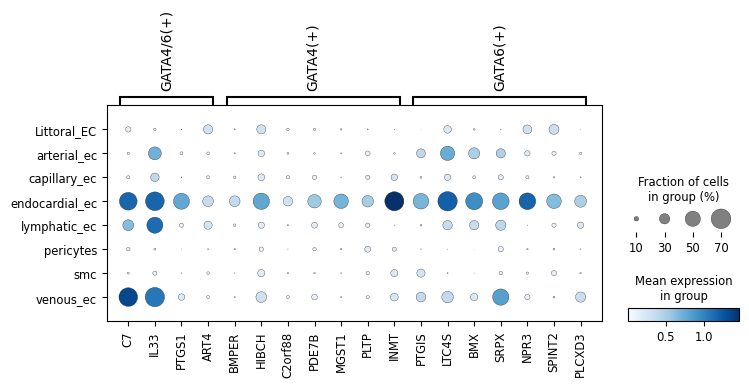

In [63]:
sc.pl.dotplot(ad, var_names={'GATA4/6(+)' : ['C7', 'IL33', 'PTGS1','ART4'], 
                             'GATA4(+)' : ['BMPER', 'HIBCH',  'C2orf88', 'PDE7B', 'MGST1', 'PLTP', 'INMT'],
                             'GATA6(+)' : ['PTGIS', 'LTC4S', 'BMX', 'SRPX', 'NPR3', 'SPINT2', 'PLCXD3']
                            },
              groupby='scenic_compartment', cmap="Blues")


In [64]:
ad.obs['endocardium_plot'] = ad.obs['scenic_compartment']
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].astype(str)

In [65]:
np.unique(ad.obs['endocardium_plot'])

array(['Littoral_EC', 'arterial_ec', 'capillary_ec', 'endocardial_ec',
       'lymphatic_ec', 'pericytes', 'smc', 'venous_ec'], dtype=object)

In [66]:
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].replace('arterial_ec', 'BEC')
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].replace('capillary_ec', 'BEC')
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].replace('venous_ec', 'BEC')
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].replace('pericytes', 'Mural')
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].replace('smc','Mural')
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].replace('lymphatic_ec', 'LEC')
ad.obs['endocardium_plot'] = ad.obs['endocardium_plot'].replace('endocardial_ec','Endocardium')

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


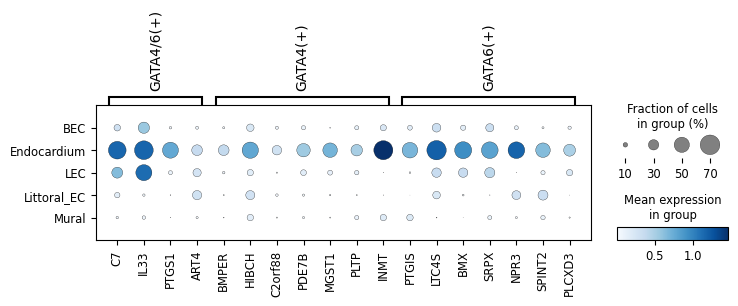

In [68]:
sc.pl.dotplot(ad, var_names={'GATA4/6(+)' : ['C7', 'IL33', 'PTGS1','ART4'], 
                             'GATA4(+)' : ['BMPER', 'HIBCH',  'C2orf88', 'PDE7B', 'MGST1', 'PLTP', 'INMT'],
                             'GATA6(+)' : ['PTGIS', 'LTC4S', 'BMX', 'SRPX', 'NPR3', 'SPINT2', 'PLCXD3']
                            },
              groupby='endocardium_plot', cmap="Blues")


In [69]:
TFs_of_interest = ['GATA4(+)'] #, 'HAND2(+)'

# Initialize an empty list to store the pairs
pairs = []

# Iterate through TFs of interest and their intersection sets
for TF in TFs_of_interest:
    intersection_set = set(inter_target_gene).intersection(set(regulons[TF]))
    for gene in intersection_set:
        pairs.append((TF, gene))

# Print the list of pairs
pairs # + [('IRX3(+)', 'IRX3')]

[('GATA4(+)', 'BMPER'),
 ('GATA4(+)', 'HIBCH'),
 ('GATA4(+)', 'IL33'),
 ('GATA4(+)', 'PTGS1'),
 ('GATA4(+)', 'C7'),
 ('GATA4(+)', 'ART4'),
 ('GATA4(+)', 'C2orf88'),
 ('GATA4(+)', 'PDE7B'),
 ('GATA4(+)', 'MGST1'),
 ('GATA4(+)', 'PLTP'),
 ('GATA4(+)', 'INMT')]

In [70]:
G = nx.Graph()
G.clear()
G.add_edges_from(pairs)

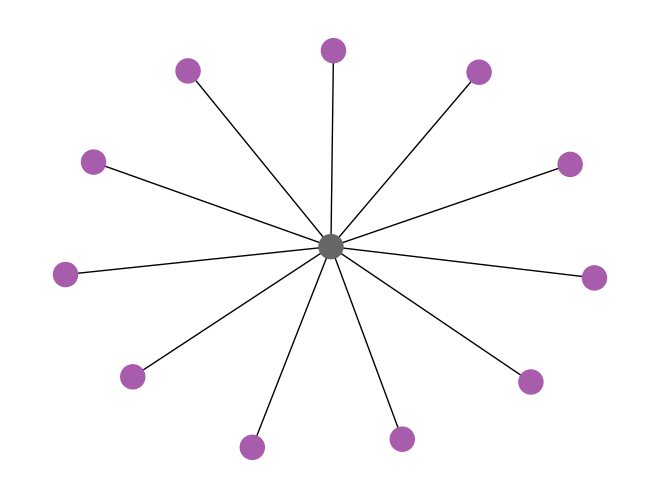

In [71]:
options = {
    "node_color": ["#666666" if '(+)' in gene else 
                   "#a85cac" for gene in list(G.nodes)],
    # "width": 2,
    # "node_size":500
    }
nx.draw(G, # with_labels=True,
       **options)
plt.show()